# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v6 code is a final, cleaned and commented version.
This version, wrt to v7, can be used as a coding playground with the goal of making the code, and in particular the calibration procedure, faster.

What has changed:
- in the code of the model, dataframe substituted with array of list comprehension to make calculation faster
- in the code of the model, WCM implemented as single line, calibration as a result is slightly slower

Next steps:
- ET calculated on hourly basis with FAO56-PM
- statistical analysis of parameters to determine correlation between them
- LAI retrieval
- use 2020 database (calibration? validation? ...) [need to solve NDVI issue]
- threshold on KGE and run again to improve estimation of parameters and assess shape of distributions

# Dependencies

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
# from modules.pyeto import *

# KEEP YOUR MODELS IN THE NOTEBOOK UNTIL THEY ARE PERFECT
# CAUSE EXTERNAL IMPORT IS AWFUL IN JUPYTER
# NOW THEY PERFECT!!
from IRRI_WCM.IRRI_WCM_model import *

In [2]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

In [3]:
def gauss(x, A, mean, dev):
    """Not-normalized, shifted gaussian distribution."""
    import math
    return A*(1/(dev*np.sqrt(2*math.pi)))*np.exp(-(x-mean)**2/(2*dev**2))

def skew_gauss(x, A, mean, dev, alpha):
    """Skew, not-normalized and shifted gaussian distribution."""

    import math
    import scipy.special as sp
    
    pdf = (1/(dev*np.sqrt(2*np.pi)))*np.exp(-pow((x-mean),2)/(2*pow(dev,2)))
    cdf = sp.erfc((-alpha*(x-mean))/(dev*np.sqrt(2)))
    return A*pdf*cdf

def hist_gauss_fit(data, nbins, hist_kwargs, fitline_kwargs,
                   title, density=False,
                   opt_save=False, dir_name='', opt_name='hist_fit',
                   func=gauss,
                  ):
    """Histogram with automatic gaussian fit.
    
    Arguments
    ---------
    - func: object, default gauss
        WARNING: skew_gauss not supported yet    
        
    """

    x = np.linspace(min(data), max(data), 200)
    counts, bins, pads = plt.hist(data, bins=nbins, density=density, **hist_kwargs)
    if func==gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))] ]
    elif func==skew_gauss:
        fit_bounds = [ [0,min(bins),0],
                      [sum(counts)*np.diff(bins)[0],max(bins),abs(max(bins)-min(bins))],
                      # [-10, 10]
                     ]
    else: raise ValueError(f'Func {func} is not a valid option.')
    popt, pcov = curve_fit(func, bins[:-1], counts, method='trf',bounds=fit_bounds, maxfev=1000)
    fit = func(x, *popt)
    plt.plot(x, fit, **fitline_kwargs)
    ylabel = 'Density' if density else 'Counts'; plt.ylabel(ylabel)
    plt.legend(loc='best'); plt.title(title)
    xtext= 0.5*(plt.xlim()[1]-plt.xlim()[0])+plt.xlim()[0] # 0.8*(max(x)-min(x))+min(x);
    ytext=0.5*max(counts) #0.5*(max(counts)-min(counts))+min(counts)
    t = plt.text(xtext, ytext,
                 f'tot counts={len(data)}\nmean={popt[1]:.2f}\ndev={popt[2]:.2f} ({popt[2]/abs(popt[1])*100:.1f}%)',
                 ha="center", va="center", size=15,
                 bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
    
    if opt_save: plt.savefig(dir_name+opt_name+'.png', dpi=300)
    
    return [counts, bins, pads, popt, pcov]

# IRRI+WCM

# IRRI+WCM, all params

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

**Time resampling consistency**

- $\sigma^0$ values are extracted with a timestamp aaaa-mm-dd hh:mm:ss with frequency 'H' (hourly), then are rounded by `.round()` to the midnight of the nearest day to have frequency 'D' (daily), e.g. a passage at 7 am on 1st july is rounded to 0 am of 1st july, a passage at 7 pm would be rounded at 0 am of 2nd july.
- many quantities need to be resampled from hourly to daily datasets: use the `.resample()` method on a dataframe with hourly DatetimeIndex and pass the argument `origin='end_day'`. In this way, for each day X, data are considered between hours 1 and 24(=0 of day X+1) and the timestamp assigned is the one of the day X+1 (on which the operation ends). 

In [4]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = True if input('Do you want to estimate irrigation as well as soil moisture? [y/n]')=='y' else False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = 'sigma0'
opt_cost = 'KGE'

PAR_str_add = input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

Starting...
#-------------------------------------------------------------



Verbose data extraction? (Describe datasets/files) [y/n] n



#-------------SWB model parameters-------------


Do you want to estimate irrigation as well as soil moisture? [y/n] n
Do you want to calibrate on year 2017 or 2020? [2017/2020] 2017
Daily or hourly frequency? [d/h] h



#-------------WCM model parameters-------------


Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db] lin



#------------Optimization parameters-----------


Any addition to parameters' names? [Type string to add] 
Number of runs? (10 is min to study distribution of parameters.)  100
Number of particles:  20
Number of optimization steps:  200
Global or Local PSO optimizer? [[global]/local]  
Verbose during calibration? [y/n] y
Run and save everything automatically? [y/n] y


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [5]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

After long and deep thinking \
and at least ten coffee drinking \
I have reached the conclusion \
that the best possible solution \
for the inputs' database \
is in fact the easiest case: \
take each column as it is, \
resample, sum or take the mean, \
give a name to every one \
and please take it easy for once!

In [6]:
# Build inputs as timeseries (using the nominal function)
# timeseries(dates, data) -> matrix[columns={dates, data}]

In [7]:
from IRRI_WCM.EPOT_Hargreaves_pyeto import *

lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [8]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [9]:
sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()

41.278799295425415

In [10]:
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : 41.278799295425415)

In [11]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
if verbose: ndvi_df.info()

# Input data

In [12]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         right_on='Date', left_on='Datetime', right_index=True)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

Let me make another coffee \
as I'd like to tell you a story: \
there was a warrior once \
that rode a python through the lands \
and everywhere she went \
her model could converge \
until an error rose from the hourly database \
ruby red, spitting fire, with three heads: \
all the particles were lost, with no \
position, velocity, energy or goal. \
But then the sky was opened by a shear of light: \
"Beware, my dear," - a deep voice rumbled - \
"of nans: your guard shoul always be up \
against missing input values! \
And don't you dare dropna: \
linearly interpolate, as you must!"

---
**ChatGPT upgrade in ironic, old-english style**

Verily, 'tis a tale most curious, \
Of a warrior bold and fierce, \
Who rode upon a serpent thus, \
And traversed the lands without a peer. 
 
But lo, a glitch did arise, \
In her model's calculations grand, \
A ruby-red error did surprise, \
With three heads, spitting fire like a dragon. 
 
All particles were lost, astray, \
With nary a position or a goal, \
The sky did open in a blaze, \
And a voice, deep and ominous, did toll: 
 
"Beware, O warrior fair, \
Of nans, for they are most vile, \
Let thy guard ever be aware, \
Against missing input values all the while." 
 
And so the warrior did learn, \
To keep a watchful eye, \
And with her python did return, \
To conquer all the lands, high and dry. 
 
Pray, heed the lesson well, \
For nans are ever present, \
And a vigilant guard, doth tell, \
Of victory, most evident. 

In [13]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   916 non-null    object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [14]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.



In [15]:
# List of 2017 and 2020 dates

# Complete days in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Days of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [16]:
P       = input_swb.loc[t]['Pioggia[mm]'] # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'] # [mm]
EPOT    = input_swb.loc[t]['EPOT'] # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'] # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'] # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'] # [-]
theta   = input_wcm.loc[t_sat]['Angle'] # [°]
VV      = input_wcm.loc[t_sat]['VV'] # [dB]
VH      = input_wcm.loc[t_sat]['VH'] # [dB]
CR      = input_wcm.loc[t_sat]['CR'] # [-]

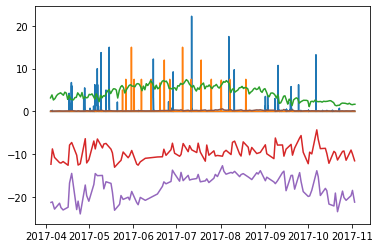

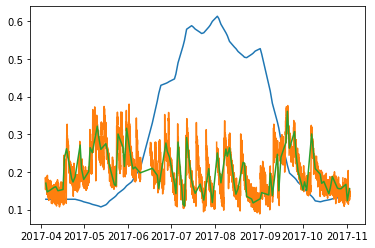

In [17]:
for x in [P,IRR_obs,EPOT,VV,VH,CR]: plt.plot(x)
plt.show()
for x in [veg,WW_obs,WW_sat]: plt.plot(x)

# Calibration SWB+WCM

In [18]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')
start = time.time()

A=0.3; B=1.5; C=-15; D=30 # guess params for WCM
W_max=    10;   # [mm] water content, maximum (not normalized)
WW_fc=    0.32; # [m3/m3] water content at field capacity
WW_w=     0.08; # [m3/m3] water content at wilting point
rho_st=   0.4;  # [-] crop specific depletion fraction
Kc0=      1;  # [-] crop specific coefficient
if freq=='h': rho_st/=24; Kc0/=24

# PAR string of names
PAR_str = ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
if units=='db': PAR_str = [el + '_db' for el in PAR_str]
# if not PAR_str_add=='': PAR_str = [el+PAR_str_add for el in PAR_str]

PAR     = [A, B, C, D, W_max, WW_fc, WW_w, rho_st, Kc0]
PARn_str= ['A', 'B', 'C', 'D', 'W_max', 'WW_fc', 'WW_w', 'rho_st', 'Kc0']
inputs  = [t, t_sat, P, IRR_obs, EPOT, WW_obs, WW_sat, veg, theta, VV]
user_in = [irri, units]

if units=='lin':
    bounds = (
        np.array([0.1, 0.1, -30, 10,   1, 0.3, 0.01, 0.01, 0.001]), # low
        np.array([5,   5,   -1, 50, 150, 0.5, 0.20, 0.8,  1.5/24]), # up
    )
elif units=='db':
    bounds = (
        np.array([ -20, 0.1, -20, 10,   1, 0.3, 0.08, 0.01, 0.001]), # low
        np.array([ -10, 3,   -10, 50, 150, 0.4, 0.15, 0.8,  1.5]), # up
    )
else: raise NameError(f'Scale can only be lin or db but {scale} was provided.')

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

params = []
for i in range(int(nrun)):
    print('Run number ', i+1, '...\n')
    if (optim=='global')or(optim==''):
        optim='global'
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
        oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                            dimensions=len(PAR),
                                            options=options,
                                            bounds=bounds,
                                            oh_strategy=oh_strategy,
                                           )
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles,
                                           dimensions=len(PAR),
                                           options=options,
                                           bounds=bounds,
                                           oh_strategy={"w":'exp_decay',
                                                         'c1':'lin_variation',
                                                         'c2':'lin_variation'})
    else: raise NameError('Please provide an accepted option.')
    
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)#, **PAR)
    params.append(PARn)

end = time.time()
timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)

2023-02-02 00:37:54,145 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Starting calibration...
#-------------------------------------------------------------

Run number  1 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 00:43:57,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31457295836274246, best pos: [ 3.81481088e-01  5.30839896e-01 -1.49947986e+01  2.36158557e+01
  9.41923013e+00  4.09976322e-01  1.30716894e-01  2.53833992e-01
  1.38556214e-02]
2023-02-02 00:43:57,821 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  2 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.322
2023-02-02 00:50:17,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3215040399172062, best pos: [ 5.28935240e-01  2.72047450e-01 -1.28320360e+01  1.66070279e+01
  6.93085813e+00  4.22299592e-01  4.96476863e-02  3.60696196e-01
  1.37606257e-02]
2023-02-02 00:50:17,686 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  3 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 00:56:35,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31352589942278175, best pos: [ 4.10929102e-01  4.59638439e-01 -1.64993121e+01  3.01330858e+01
  1.17810472e+01  3.66824202e-01  1.49444754e-01  1.98389263e-01
  1.36114530e-02]
2023-02-02 00:56:35,406 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  4 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 01:02:47,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28875324364749466, best pos: [ 4.35823744e-01  4.07075134e-01 -1.66926406e+01  2.86404680e+01
  2.97110064e+00  3.77919677e-01  1.57292577e-01  2.78931919e-01
  3.90016864e-03]
2023-02-02 01:02:47,596 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  5 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.294
2023-02-02 01:08:56,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2942945668191367, best pos: [ 3.34742855e-01  8.97933310e-01 -1.66293894e+01  3.53681206e+01
  4.58506639e+00  3.32475520e-01  1.69985704e-01  3.35570826e-01
  4.84066362e-03]
2023-02-02 01:08:56,762 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  6 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.319
2023-02-02 01:15:13,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3191789807695087, best pos: [ 3.73243277e-01  5.86489882e-01 -1.31977050e+01  2.07476467e+01
  7.75683036e+00  3.82857013e-01  6.64488181e-02  3.67355186e-01
  1.25362608e-02]
2023-02-02 01:15:13,930 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  7 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 01:21:32,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29210095946303616, best pos: [ 3.82321416e-01  6.28946392e-01 -1.33360971e+01  2.12322281e+01
  2.77884012e+00  3.70578955e-01  3.21458119e-02  2.78291909e-01
  4.75789695e-03]
2023-02-02 01:21:32,111 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  8 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 01:27:50,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31377347926371857, best pos: [ 3.82074184e-01  5.36590464e-01 -1.58512726e+01  2.80164722e+01
  1.08718670e+01  3.75695036e-01  1.38132570e-01  2.19160468e-01
  1.35379817e-02]
2023-02-02 01:27:50,817 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  9 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 01:34:10,167 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2889950394080931, best pos: [ 3.58448319e-01  7.50119896e-01 -1.49282711e+01  2.35945549e+01
  3.14871223e+00  4.14369190e-01  9.88148216e-02  2.01091628e-01
  5.05280769e-03]
2023-02-02 01:34:10,172 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  10 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 01:40:23,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31506211878077617, best pos: [ 3.54687130e-01  6.19824471e-01 -1.30726936e+01  1.59826909e+01
  4.20182248e+00  4.79885916e-01  3.22062676e-02  1.99118641e-01
  1.09412210e-02]
2023-02-02 01:40:24,001 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  11 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.303
2023-02-02 01:46:34,242 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30264127449533706, best pos: [ 4.81764320e-01  3.41903765e-01 -1.75084823e+01  2.99471382e+01
  6.99662295e+00  3.95950540e-01  1.77381604e-01  1.50166652e-01
  8.68163252e-03]
2023-02-02 01:46:34,247 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  12 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 01:52:30,977 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28866546986521047, best pos: [ 5.07175790e-01  3.43852447e-01 -1.66445094e+01  3.03277492e+01
  3.12772060e+00  3.49627595e-01  1.35271663e-01  2.63309489e-01
  3.58949623e-03]
2023-02-02 01:52:30,982 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  13 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.297
2023-02-02 01:58:29,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2970657748882961, best pos: [ 4.17442556e-01  4.37482978e-01 -1.55298745e+01  2.60579895e+01
  3.62973897e+00  3.90091307e-01  1.54850131e-01  2.94691520e-01
  5.09984425e-03]
2023-02-02 01:58:29,823 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  14 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 02:04:28,993 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31580272067026494, best pos: [ 4.24357163e-01  4.13776405e-01 -1.45928740e+01  2.18743467e+01
  8.73450161e+00  4.16457047e-01  1.21241463e-01  2.73009476e-01
  1.44579188e-02]
2023-02-02 02:04:28,999 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  15 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.295
2023-02-02 02:10:28,345 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29464581090525876, best pos: [ 3.89441850e-01  6.89191137e-01 -1.35919827e+01  2.50658676e+01
  3.45023975e+00  3.39313484e-01  5.11591577e-02  2.61858996e-01
  5.18592300e-03]
2023-02-02 02:10:28,352 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  16 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 02:16:29,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31530500465035505, best pos: [ 3.67943314e-01  6.07254690e-01 -1.40940043e+01  1.97880328e+01
  7.22551711e+00  4.47818910e-01  1.09294885e-01  2.66453187e-01
  1.26717070e-02]
2023-02-02 02:16:29,339 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  17 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 02:22:49,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2921864785932473, best pos: [ 3.74775241e-01  7.01389648e-01 -1.43181781e+01  2.76216415e+01
  3.51358904e+00  3.22991043e-01  5.53891119e-02  2.84332080e-01
  4.44497939e-03]
2023-02-02 02:22:49,794 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  18 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 02:29:10,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28894409049913716, best pos: [ 3.73713852e-01  6.34786294e-01 -1.47073442e+01  2.26040643e+01
  3.07663627e+00  4.09826036e-01  1.01208488e-01  2.79191480e-01
  4.79152127e-03]
2023-02-02 02:29:10,530 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  19 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 02:35:30,308 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2901470169595164, best pos: [ 4.33244141e-01  4.72627077e-01 -1.61869284e+01  2.86342793e+01
  4.13419208e+00  3.63103597e-01  1.28019616e-01  2.52044251e-01
  4.93750720e-03]
2023-02-02 02:35:30,315 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  20 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.296
2023-02-02 02:41:47,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2957996175439328, best pos: [ 3.43879815e-01  1.01322541e+00 -1.37328221e+01  2.82905583e+01
  2.61297769e+00  3.19818908e-01  6.45725981e-02  3.63079808e-01
  3.56244996e-03]
2023-02-02 02:41:47,409 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  21 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 02:48:05,927 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2902042527158869, best pos: [ 3.40359418e-01  8.31973360e-01 -1.93259366e+01  3.75822256e+01
  4.75519199e+00  3.78886669e-01  1.80009847e-01  1.17385510e-01
  4.80660395e-03]
2023-02-02 02:48:05,933 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  22 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.296
2023-02-02 02:54:19,129 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2958896926338057, best pos: [ 3.43081183e-01  7.59586797e-01 -1.68644138e+01  3.83818388e+01
  5.36478886e+00  3.08897569e-01  1.79216697e-01  3.23729748e-01
  5.08118159e-03]
2023-02-02 02:54:19,134 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  23 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 03:00:36,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2906044156799743, best pos: [ 3.56119200e-01  7.81683181e-01 -1.51051196e+01  3.11696194e+01
  4.01482452e+00  3.19238891e-01  8.54239077e-02  2.70260595e-01
  4.61624277e-03]
2023-02-02 03:00:36,209 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  24 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 03:06:52,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2877747166250453, best pos: [ 3.68735244e-01  6.69597232e-01 -1.55619539e+01  2.25532766e+01
  2.85545907e+00  4.48483268e-01  1.27114759e-01  2.18685018e-01
  4.51403079e-03]
2023-02-02 03:06:52,941 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  25 ...



pyswarms.single.global_best: 100%|██████████████████████████████████████████████████████████████|200/200, best_cost=0.3
2023-02-02 03:13:06,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30039859522123524, best pos: [ 3.84355189e-01  5.41366646e-01 -1.35737391e+01  1.63592431e+01
  3.52932508e+00  4.99798283e-01  9.65927066e-02  3.24440919e-01
  7.79387297e-03]
2023-02-02 03:13:06,798 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  26 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 03:19:12,491 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29204111551687895, best pos: [ 7.15348815e-01  1.99012256e-01 -1.62255107e+01  2.61287040e+01
  2.70619304e+00  3.75215281e-01  1.31203806e-01  2.55922026e-01
  3.55948103e-03]
2023-02-02 03:19:12,496 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  27 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 03:25:10,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31435754982069697, best pos: [ 3.66837682e-01  5.82454013e-01 -1.49486788e+01  2.17164172e+01
  8.50732600e+00  4.48458001e-01  1.43125666e-01  2.57780397e-01
  1.38112895e-02]
2023-02-02 03:25:10,195 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  28 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.319
2023-02-02 03:31:07,943 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.319162501022455, best pos: [ 3.62578605e-01  6.32778623e-01 -1.58866464e+01  3.26051882e+01
  1.41436921e+01  3.24736164e-01  1.24020910e-01  2.27659235e-01
  1.54056444e-02]
2023-02-02 03:31:07,949 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  29 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 03:37:05,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31575958834427975, best pos: [ 3.50245633e-01  7.61410211e-01 -1.47769833e+01  2.45167564e+01
  9.03141326e+00  4.04271382e-01  1.21226201e-01  2.43292973e-01
  1.27986101e-02]
2023-02-02 03:37:05,943 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  30 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 03:43:05,059 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2905976098109728, best pos: [ 3.86690563e-01  5.40406410e-01 -1.44431422e+01  2.32779707e+01
  3.01071756e+00  3.73151222e-01  7.67504381e-02  3.23972529e-01
  4.38052423e-03]
2023-02-02 03:43:05,065 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  31 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.318
2023-02-02 03:49:03,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3175985003425552, best pos: [ 3.66096494e-01  6.14096399e-01 -1.51202741e+01  3.16775982e+01
  1.25148947e+01  3.14283473e-01  1.01564130e-01  2.45073153e-01
  1.37732024e-02]
2023-02-02 03:49:03,020 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  32 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.301
2023-02-02 03:54:54,442 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3014343487708806, best pos: [ 3.45457158e-01  8.12857162e-01 -1.18889221e+01  1.91595511e+01
  2.41429969e+00  3.55632944e-01  2.66078716e-02  7.41454833e-01
  4.47347234e-03]
2023-02-02 03:54:54,447 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  33 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.298
2023-02-02 04:00:52,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2978508377225717, best pos: [ 4.18762880e-01  4.43880696e-01 -1.89608179e+01  4.00128485e+01
  5.26801846e+00  3.42933515e-01  1.84060773e-01  1.47576745e-01
  4.97451023e-03]
2023-02-02 04:00:52,664 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  34 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.317
2023-02-02 04:06:51,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3173156279815208, best pos: [ 3.50846609e-01  6.85439963e-01 -1.31702846e+01  1.76439909e+01
  6.61867871e+00  4.58667497e-01  7.29252594e-02  2.82711718e-01
  1.31792662e-02]
2023-02-02 04:06:51,767 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  35 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.298
2023-02-02 04:12:48,113 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29844902969475284, best pos: [ 3.49811474e-01  1.15739175e+00 -1.34677961e+01  2.67064471e+01
  2.26463877e+00  3.39426127e-01  4.88050115e-02  3.09967096e-01
  3.50958889e-03]
2023-02-02 04:12:48,119 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  36 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 04:18:59,626 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3154579367845707, best pos: [ 3.61570402e-01  6.42035122e-01 -1.47208497e+01  2.35755164e+01
  9.36336325e+00  4.05616582e-01  1.19712160e-01  2.69683219e-01
  1.32641140e-02]
2023-02-02 04:18:59,632 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  37 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.309
2023-02-02 04:25:13,343 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30893940859699043, best pos: [ 3.42204381e-01  1.29792502e+00 -1.26048188e+01  2.61726115e+01
  2.94042875e+00  3.49358431e-01  2.55453453e-02  2.36325380e-01
  4.55041916e-03]
2023-02-02 04:25:13,349 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  38 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 04:31:30,970 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29105170438225225, best pos: [ 3.82519843e-01  6.22735450e-01 -1.64221631e+01  2.75308126e+01
  4.34147943e+00  3.98276482e-01  1.37994764e-01  1.85464109e-01
  5.57527632e-03]
2023-02-02 04:31:30,975 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  39 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 04:37:49,010 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31489414756727774, best pos: [ 3.72434850e-01  6.11894351e-01 -1.61259915e+01  3.30953476e+01
  1.27685068e+01  3.33778160e-01  1.28661481e-01  2.08935207e-01
  1.37976728e-02]
2023-02-02 04:37:49,015 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  40 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 04:44:07,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3159734166460648, best pos: [ 4.00954044e-01  5.22853914e-01 -1.47297071e+01  2.60361473e+01
  9.57030196e+00  3.60109002e-01  1.02718411e-01  2.40426438e-01
  1.27568725e-02]
2023-02-02 04:44:07,256 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  41 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 04:50:25,047 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28961090175660664, best pos: [ 4.54285116e-01  4.28604211e-01 -1.54332756e+01  2.14744330e+01
  2.79994819e+00  4.49632912e-01  1.31703655e-01  2.40010720e-01
  4.67608540e-03]
2023-02-02 04:50:25,053 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  42 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.315
2023-02-02 04:56:41,976 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31496563307189795, best pos: [ 3.74313344e-01  5.58868382e-01 -1.58120742e+01  2.90849383e+01
  1.20082650e+01  3.66329214e-01  1.38049525e-01  2.27020487e-01
  1.48429147e-02]
2023-02-02 04:56:41,982 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  43 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 05:02:57,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2914046761695337, best pos: [ 3.61607212e-01  7.60103029e-01 -1.38657041e+01  2.45448241e+01
  3.11427616e+00  3.52277118e-01  5.35573308e-02  2.88956335e-01
  4.48703963e-03]
2023-02-02 05:02:57,399 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  44 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.318
2023-02-02 05:09:15,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31844265707062047, best pos: [ 3.24853338e-01  7.38854530e-01 -1.42160962e+01  2.45696934e+01
  9.13105785e+00  3.71661559e-01  9.22579266e-02  2.76236175e-01
  1.27823240e-02]
2023-02-02 05:09:15,372 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  45 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.317
2023-02-02 05:15:30,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3166446831834402, best pos: [ 4.04128541e-01  4.61757893e-01 -1.50824364e+01  2.87283908e+01
  1.12955023e+01  3.33983769e-01  1.06482567e-01  2.63815490e-01
  1.33913548e-02]
2023-02-02 05:15:30,739 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  46 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 05:21:29,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28767682747166545, best pos: [ 3.54915623e-01  7.48015216e-01 -1.96921247e+01  4.49274558e+01
  5.89553374e+00  3.22417240e-01  1.61323137e-01  1.40196585e-01
  4.81567779e-03]
2023-02-02 05:21:29,658 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  47 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 05:27:28,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29113083995639877, best pos: [ 3.60549313e-01  7.62172515e-01 -2.00636901e+01  4.75568757e+01
  6.50285635e+00  3.17038350e-01  1.71184010e-01  1.31817191e-01
  4.81459585e-03]
2023-02-02 05:27:28,621 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  48 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 05:33:26,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2894016019046437, best pos: [ 4.46394526e-01  4.44287819e-01 -1.80088782e+01  3.62961097e+01
  4.85271937e+00  3.35111776e-01  1.37634450e-01  1.41467227e-01
  4.64771703e-03]
2023-02-02 05:33:26,759 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  49 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.303
2023-02-02 05:39:25,762 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.302527502531043, best pos: [ 5.02449583e-01  3.51493581e-01 -1.51051306e+01  3.00026308e+01
  5.80140238e+00  3.04907442e-01  7.78520460e-02  2.20538442e-01
  6.15295959e-03]
2023-02-02 05:39:25,768 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  50 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.319
2023-02-02 05:45:23,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31851751667119965, best pos: [ 3.41128420e-01  7.16894282e-01 -1.31013381e+01  1.78977006e+01
  6.19586368e+00  4.50484024e-01  5.88707628e-02  2.13464922e-01
  1.28219789e-02]
2023-02-02 05:45:23,664 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  51 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.307
2023-02-02 05:51:22,484 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30671235725581736, best pos: [ 5.36346925e-01  2.92762073e-01 -1.77373996e+01  3.50386286e+01
  7.82783132e+00  3.26885235e-01  1.48279242e-01  1.43485398e-01
  8.12905205e-03]
2023-02-02 05:51:22,490 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  52 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 05:57:20,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2923436835103953, best pos: [ 3.85286711e-01  5.91102966e-01 -1.39409187e+01  2.33172410e+01
  3.33500520e+00  3.60758484e-01  5.76596418e-02  2.95394324e-01
  5.00705129e-03]
2023-02-02 05:57:20,290 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  53 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 06:03:18,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31586369720092533, best pos: [ 5.01733689e-01  3.02148687e-01 -1.53043860e+01  2.09836716e+01
  8.95093612e+00  4.58575987e-01  1.58959628e-01  2.58134640e-01
  1.48684143e-02]
2023-02-02 06:03:18,890 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  54 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.287
2023-02-02 06:09:16,776 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2873098376810491, best pos: [ 3.54493981e-01  7.72882885e-01 -1.77610705e+01  3.52315881e+01
  4.51368183e+00  3.57181517e-01  1.46441987e-01  1.73887647e-01
  4.62101207e-03]
2023-02-02 06:09:16,782 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  55 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 06:15:13,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2912466776167103, best pos: [ 3.53616555e-01  8.19950306e-01 -1.52267312e+01  3.24210327e+01
  3.10854124e+00  3.08468726e-01  8.42756131e-02  2.69864578e-01
  3.63199923e-03]
2023-02-02 06:15:13,427 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  56 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 06:21:29,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3144777943640862, best pos: [ 3.64471314e-01  6.12996505e-01 -1.55217311e+01  2.28317119e+01
  9.29411867e+00  4.52575792e-01  1.61399430e-01  2.42193368e-01
  1.38302924e-02]
2023-02-02 06:21:29,532 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  57 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.293
2023-02-02 06:27:44,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2932252372971458, best pos: [ 3.41472588e-01  8.08306239e-01 -2.02213448e+01  4.16109886e+01
  5.38906519e+00  3.63600270e-01  1.78884467e-01  4.35522754e-02
  5.35034226e-03]
2023-02-02 06:27:44,794 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  58 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.318
2023-02-02 06:34:01,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31774169550779763, best pos: [ 4.14769157e-01  4.43901184e-01 -1.43253847e+01  2.42599082e+01
  1.01231703e+01  3.69331386e-01  1.01820900e-01  2.76446631e-01
  1.49709515e-02]
2023-02-02 06:34:01,205 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  59 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 06:40:15,208 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3135333971105514, best pos: [ 3.56418974e-01  6.15885553e-01 -1.69471105e+01  3.21562229e+01
  1.24065520e+01  3.65186011e-01  1.53619001e-01  1.82797335e-01
  1.37089814e-02]
2023-02-02 06:40:15,213 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  60 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 06:46:31,354 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29063831363246695, best pos: [ 4.06639035e-01  5.01582216e-01 -1.51739922e+01  2.66478071e+01
  3.64309800e+00  3.55502078e-01  1.00419098e-01  2.92998934e-01
  4.82618243e-03]
2023-02-02 06:46:31,359 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  61 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.355
2023-02-02 06:52:46,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3552945010541262, best pos: [ 3.78687510e-01  4.76561839e-01 -1.64883456e+01  2.61118093e+01
  1.85106653e+01  4.39143904e-01  1.76737959e-01  1.50151511e-02
  4.02654830e-02]
2023-02-02 06:52:46,666 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  62 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 06:59:03,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3160304715348572, best pos: [ 5.51230449e-01  2.58902211e-01 -1.53634887e+01  2.21420408e+01
  8.70548260e+00  4.31321470e-01  1.50519826e-01  2.60218521e-01
  1.36661928e-02]
2023-02-02 06:59:03,883 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  63 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 07:05:20,510 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29051942950613463, best pos: [ 3.74391601e-01  6.53736606e-01 -1.43791665e+01  2.32704057e+01
  3.28142611e+00  3.91072352e-01  8.05423370e-02  2.56206902e-01
  5.00864294e-03]
2023-02-02 07:05:20,515 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  64 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 07:11:37,592 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28861531335919854, best pos: [ 3.63860634e-01  6.95144971e-01 -1.57343848e+01  2.30713241e+01
  3.05194813e+00  4.57506511e-01  1.47140890e-01  2.07305292e-01
  4.96626536e-03]
2023-02-02 07:11:37,598 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  65 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.301
2023-02-02 07:17:46,986 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30071448165233583, best pos: [ 3.98486044e-01  4.69534596e-01 -1.84120579e+01  3.95677912e+01
  8.00766895e+00  3.31728762e-01  1.59438512e-01  1.74792658e-01
  7.47181387e-03]
2023-02-02 07:17:46,992 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  66 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 07:23:46,284 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.290162055047656, best pos: [ 3.78119308e-01  6.90956370e-01 -1.54571256e+01  3.03555074e+01
  3.94515507e+00  3.33892477e-01  7.83873068e-02  1.36465720e-01
  4.81201518e-03]
2023-02-02 07:23:46,289 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  67 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.291
2023-02-02 07:29:41,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29096235034282214, best pos: [ 3.37815139e-01  1.04936247e+00 -1.68407600e+01  3.84868720e+01
  4.70074786e+00  3.18920950e-01  1.17339467e-01  2.02079442e-01
  4.48816008e-03]
2023-02-02 07:29:41,610 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  68 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.296
2023-02-02 07:35:39,407 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2960396595065824, best pos: [ 3.24020124e-01  1.42128802e+00 -1.69159327e+01  3.63737632e+01
  4.32848995e+00  3.53695522e-01  1.30769900e-01  1.77462273e-01
  4.57259189e-03]
2023-02-02 07:35:39,412 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  69 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 07:41:37,856 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29151491122293305, best pos: [ 4.56461086e-01  4.32105729e-01 -1.46441923e+01  2.42420843e+01
  3.20034600e+00  3.65642389e-01  8.68929335e-02  3.05034907e-01
  4.51593562e-03]
2023-02-02 07:41:37,861 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  70 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 07:47:37,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31375637088802344, best pos: [ 3.90139399e-01  5.14047681e-01 -1.73674140e+01  3.23418698e+01
  1.29662782e+01  3.74924255e-01  1.69349239e-01  1.61479023e-01
  1.47696471e-02]
2023-02-02 07:47:37,159 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  71 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.349
2023-02-02 07:53:38,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3491710984125391, best pos: [  0.37679292   0.58971135 -12.46422193  15.61269485  11.69079648
   0.46609578   0.02204932   0.20384055   0.02376622]
2023-02-02 07:53:38,344 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  72 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.317
2023-02-02 07:59:37,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31675911496433407, best pos: [ 3.31558237e-01  7.02249059e-01 -1.48042153e+01  2.52477329e+01
  9.86861033e+00  3.85902445e-01  1.17193945e-01  2.61707218e-01
  1.39044369e-02]
2023-02-02 07:59:37,539 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  73 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 08:05:45,665 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28903101319620306, best pos: [ 3.42319982e-01  7.15732780e-01 -1.71981705e+01  3.41752547e+01
  4.57526002e+00  3.48383820e-01  1.43082250e-01  2.26698439e-01
  4.95041809e-03]
2023-02-02 08:05:45,670 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  74 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 08:12:07,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2879869802244295, best pos: [ 3.88280805e-01  5.88226200e-01 -1.59527176e+01  2.73943996e+01
  3.57803685e+00  3.80902098e-01  1.23625817e-01  2.32932043e-01
  4.67247185e-03]
2023-02-02 08:12:07,066 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  75 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 08:18:20,030 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3137436442875363, best pos: [ 3.71260019e-01  5.74946932e-01 -1.64107072e+01  2.97450075e+01
  1.17341444e+01  3.74751891e-01  1.50153477e-01  2.13846870e-01
  1.35299015e-02]
2023-02-02 08:18:20,035 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  76 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.293
2023-02-02 08:24:35,962 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.292868415044753, best pos: [ 3.63028728e-01  6.96724150e-01 -1.29850349e+01  1.84773425e+01
  2.56586237e+00  4.20924506e-01  5.64976917e-02  4.25303793e-01
  5.03205052e-03]
2023-02-02 08:24:35,968 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  77 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 08:30:49,740 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28995609828077806, best pos: [ 3.20221166e-01  9.54312784e-01 -1.54783715e+01  2.42551235e+01
  3.00952537e+00  4.31255092e-01  1.12517051e-01  2.02480447e-01
  4.55596230e-03]
2023-02-02 08:30:49,746 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  78 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 08:37:02,996 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2915270105876828, best pos: [ 4.48850103e-01  4.01489532e-01 -1.37645663e+01  1.62352531e+01
  2.13156994e+00  4.86593171e-01  1.03074885e-01  4.53165613e-01
  4.52281104e-03]
2023-02-02 08:37:03,001 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  79 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 08:43:17,410 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2899938832234674, best pos: [ 3.72174517e-01  7.03312591e-01 -1.60870863e+01  2.95823240e+01
  3.99136659e+00  3.62577962e-01  9.32384946e-02  8.28352976e-02
  4.98380974e-03]
2023-02-02 08:43:17,415 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  80 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.301
2023-02-02 08:49:26,646 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.30131593012341384, best pos: [ 3.45073367e-01  7.36775765e-01 -1.26006009e+01  2.27573792e+01
  2.89216396e+00  3.22275642e-01  1.46773261e-01  6.59402042e-01
  4.54643793e-03]
2023-02-02 08:49:26,651 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  81 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 08:55:41,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28788466224027065, best pos: [ 3.67213388e-01  6.60736756e-01 -1.63805054e+01  3.04428652e+01
  3.99230609e+00  3.59289121e-01  1.25259642e-01  2.22519475e-01
  4.63270980e-03]
2023-02-02 08:55:41,809 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  82 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.313
2023-02-02 09:01:58,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3130723437564522, best pos: [ 3.83663578e-01  5.37756708e-01 -1.78074712e+01  3.78171767e+01
  1.49857473e+01  3.30547873e-01  1.53073633e-01  1.57519598e-01
  1.39942960e-02]
2023-02-02 09:01:58,185 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  83 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.296
2023-02-02 09:08:12,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29604575261229904, best pos: [ 7.23787877e-01  1.75715797e-01 -1.60583793e+01  2.83145828e+01
  4.24671468e+00  3.44514080e-01  1.31889741e-01  3.18541610e-01
  5.06425980e-03]
2023-02-02 09:08:12,715 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  84 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.316
2023-02-02 09:14:28,763 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31645854638088533, best pos: [ 3.28572722e-01  7.09039090e-01 -1.68197781e+01  3.55820507e+01
  1.46081758e+01  3.33283299e-01  1.40901958e-01  1.94792517e-01
  1.51916393e-02]
2023-02-02 09:14:28,768 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  85 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 09:20:41,560 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2878820518713635, best pos: [ 3.48087065e-01  8.13283447e-01 -1.81670115e+01  3.68200350e+01
  4.63483246e+00  3.53712684e-01  1.54498544e-01  1.78204874e-01
  4.51447425e-03]
2023-02-02 09:20:41,565 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  86 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.314
2023-02-02 09:26:39,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31373241457989487, best pos: [ 3.76714162e-01  5.64143025e-01 -1.61840065e+01  2.99410450e+01
  1.16547849e+01  3.65631751e-01  1.41754983e-01  2.07197182e-01
  1.37128036e-02]
2023-02-02 09:26:39,088 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  87 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.317
2023-02-02 09:32:37,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.31716910024668477, best pos: [ 3.40030262e-01  7.30645137e-01 -1.60740387e+01  3.63754226e+01
  1.37369441e+01  3.05243402e-01  1.17132565e-01  2.37123584e-01
  1.33089688e-02]
2023-02-02 09:32:37,801 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  88 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 09:38:35,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28866247355135477, best pos: [ 3.40670088e-01  9.12339682e-01 -1.61798073e+01  3.46210177e+01
  3.42771552e+00  3.21367223e-01  1.10007799e-01  2.72977260e-01
  3.59382276e-03]
2023-02-02 09:38:35,840 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  89 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.292
2023-02-02 09:44:33,699 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2922627506381039, best pos: [ 3.23541596e-01  9.23971969e-01 -1.37851667e+01  2.26282941e+01
  2.91831825e+00  3.87077230e-01  3.34418875e-02  1.69078133e-01
  4.88376160e-03]
2023-02-02 09:44:33,705 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  90 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 09:50:31,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2879001399186425, best pos: [ 3.74701776e-01  6.21670990e-01 -1.75006450e+01  3.14052036e+01
  4.10823094e+00  3.87418099e-01  1.65011176e-01  1.85264217e-01
  4.85560838e-03]
2023-02-02 09:50:31,288 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  91 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.294
2023-02-02 09:56:29,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29437056472059064, best pos: [ 3.83344474e-01  5.15313212e-01 -1.85337107e+01  4.20907480e+01
  6.32304430e+00  3.11645313e-01  1.55162998e-01  1.67398284e-01
  5.58499762e-03]
2023-02-02 09:56:29,531 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  92 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 10:02:28,016 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28796071379462285, best pos: [ 3.48141429e-01  8.28860903e-01 -1.78814461e+01  3.86426724e+01
  4.88887828e+00  3.30576254e-01  1.32360274e-01  1.49440560e-01
  4.59528404e-03]
2023-02-02 10:02:28,022 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  93 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.299
2023-02-02 10:08:26,451 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2988804850111497, best pos: [ 8.66748267e-01  1.26615794e-01 -1.94425838e+01  4.24656207e+01
  6.95827012e+00  3.10001915e-01  1.72777669e-01  1.80625783e-01
  5.50781988e-03]
2023-02-02 10:08:26,456 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  94 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.288
2023-02-02 10:14:22,217 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2879316341978595, best pos: [ 3.77146102e-01  5.84508920e-01 -1.57490883e+01  2.15661122e+01
  2.78941202e+00  4.68317828e-01  1.59385642e-01  2.94919301e-01
  4.45706029e-03]
2023-02-02 10:14:22,222 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  95 ...



pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████|200/200, best_cost=0.29
2023-02-02 10:20:34,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2896805273475348, best pos: [ 3.82836409e-01  6.11345486e-01 -1.49889703e+01  2.69610793e+01
  3.52895185e+00  3.51920007e-01  9.32476766e-02  2.91358533e-01
  4.66792564e-03]
2023-02-02 10:20:34,428 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  96 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.289
2023-02-02 10:26:51,223 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.288900132719753, best pos: [ 4.29275049e-01  4.87428550e-01 -1.51705022e+01  2.13286237e+01
  2.80226640e+00  4.44737540e-01  1.19443385e-01  2.44829960e-01
  4.65060925e-03]
2023-02-02 10:26:51,228 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  97 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.287
2023-02-02 10:33:08,564 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.28746377652275745, best pos: [ 3.60690617e-01  7.16764874e-01 -1.75144065e+01  3.31651685e+01
  4.28798834e+00  3.69423756e-01  1.50981823e-01  1.71496256e-01
  4.65701308e-03]
2023-02-02 10:33:08,569 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  98 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.299
2023-02-02 10:39:17,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29942814355647784, best pos: [ 3.38363653e-01  8.32098179e-01 -1.57036898e+01  3.45157478e+01
  6.12399119e+00  3.12192274e-01  1.08267511e-01  2.60406093e-01
  6.77794166e-03]
2023-02-02 10:39:17,919 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  99 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.299
2023-02-02 10:45:29,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.299143735764543, best pos: [ 3.25132880e-01  1.23791538e+00 -1.22206290e+01  2.08504683e+01
  2.58603165e+00  3.74312968e-01  1.11732570e-02  3.31820949e-01
  4.73709243e-03]
2023-02-02 10:45:29,942 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.6}


Run number  100 ...



pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████████|200/200, best_cost=0.293
2023-02-02 10:51:44,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.29273362397203484, best pos: [ 3.47234334e-01  8.26134644e-01 -1.69155917e+01  2.90048847e+01
  4.28288717e+00  4.14389393e-01  1.52863789e-01  1.12740154e-01
  6.01061749e-03]


Timestring:  230202-105144


In [19]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

Timing:  6.14  min for 1 run, 613.83 min total


# Parameters' study

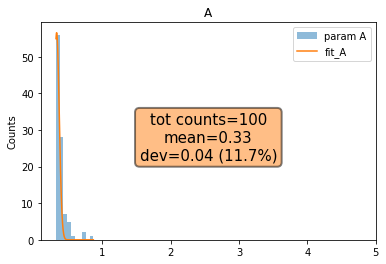

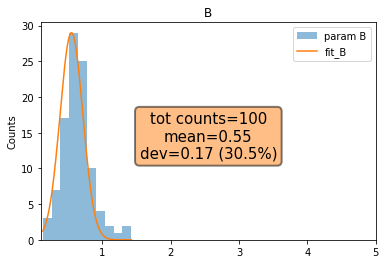

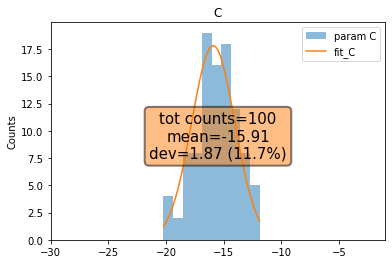

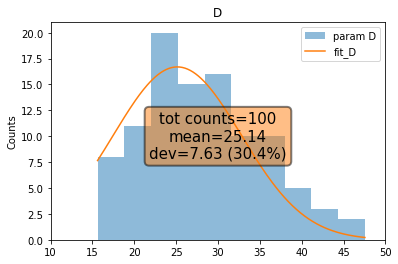

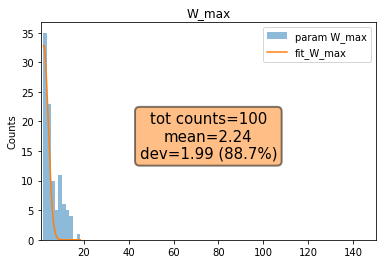

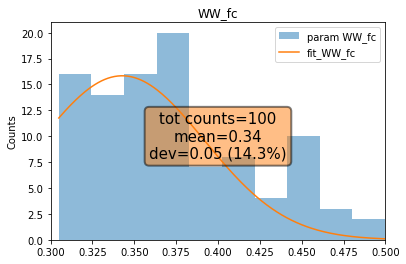

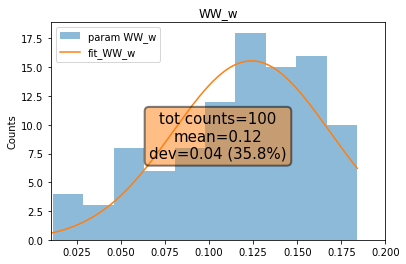

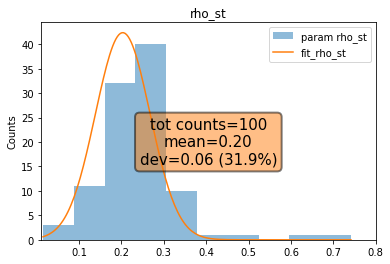

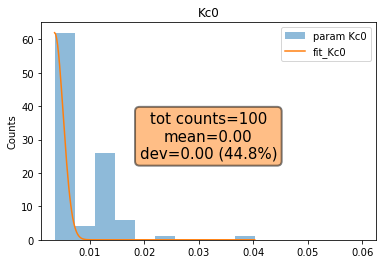

{'A': [0.3, 'cal', [0.1, 5.0], 0.33, 0.039],
 'B': [1.5, 'cal', [0.1, 5.0], 0.547, 0.167],
 'C': [-15, 'cal', [-30.0, -1.0], -15.913, 1.866],
 'D': [30, 'cal', [10.0, 50.0], 25.144, 7.632],
 'W_max': [10, 'cal', [1.0, 150.0], 2.241, 1.988],
 'WW_fc': [0.32, 'cal', [0.3, 0.5], 0.343, 0.049],
 'WW_w': [0.08, 'cal', [0.01, 0.2], 0.124, 0.044],
 'rho_st': [0.02, 'cal', [0.01, 0.8], 0.203, 0.065],
 'Kc0': [0.04, 'cal', [0.001, 0.0625], 0.004, 0.002]}

In [20]:
matrix = np.array(
    [
        np.array(
            [ params[i][j] for i in range(nrun) ])
        for j in range(len(PAR))
    ]
)

PAR_dict = {
    'A':     [round(A, 2) ],
    'B':     [round(B, 2) ],
    'C':     [round(C, 2) ],
    'D':     [round(D, 2) ],
    'W_max': [round(W_max, 2) ],
    'WW_fc': [round(WW_fc, 2) ],
    'WW_w':  [round(WW_w, 2) ],
    'rho_st':[round(rho_st, 2) ],
    'Kc0' :  [round(Kc0, 2)]
}

PARn = []
PARn_dev = []

if automate: opt_save=True
else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False

for label in PAR_dict:
    if label in PARn_str:
        i = PARn_str.index(label)
        
        if nrun==1:
            PARn=[x[0] for x in matrix]
            PARn_dev=[0 for x in matrix]
        else:
            hist_kwargs={'alpha':.5, 'label':f'param {label}'}
            fitline_kwargs={'linestyle':'-', 'label':f'fit_{label}'}
            data = matrix[i]
            nbins = 10 if nrun<100 else np.sqrt(nrun)-4
            plt.xlim(bounds[0][i], bounds[1][i]);
            counts, bins, pads, popt, pcov = hist_gauss_fit(
                data, nbins=10, hist_kwargs=hist_kwargs, fitline_kwargs=fitline_kwargs,
                title=f'{label}', density=False,
                opt_save=opt_save, dir_name='Plot\\', opt_name=f'{timestr}_hist_{label}',
                func=gauss)
            PARn.append(popt[1])
            PARn_dev.append(popt[2])    
            plt.show()
        
        PAR_dict[label].append('cal')
        PAR_dict[label].append([bounds[0][i], bounds[1][i]])
        PAR_dict[label].append(np.round(PARn[i], 3))
        PAR_dict[label].append(np.round(PARn_dev[i], 3))
    else:
        PAR_dict[label].append('fix')
        PAR_dict[label].append(['/', '/'])
        PAR_dict[label].append(PAR_dict[label][0])
        PAR_dict[label].append('/')

PAR_dict

# Model output - plots sim VS obs for SM, sigma0

In [21]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':

        # PAR  = [A, B, C, D, W_max, Kc]
        # PARn = [0.29, 3.36, -15.75, 40.92, 100.18, 0.58] # [lin]
        # PARn = [-15, 0.49, -21.06, 33.77, 100.18, 0.44] # [db] # NEED TO RUN AGAIN IF UNITS CHANGE
        # PARn = [0.29,2.14,-14.69,35.79,100,0.72] # [lin] new params Kc
        # PARn = [0.28, 0.71, -12.88, 22.78, 16.56, 0.50] # [lin] Wmax in [1,150]
        # PARn = [0.3179471,1.75074996,-18.0340179,41.18898174,100.05601716]
        # WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)
        
        # # Model version with all params
        # PARn = [0.3, 1.4, -15, 40, 100, 0.32, 0.08, 0.4/24, 0.05]
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PARn = [0.3, 3, -5, 40, 100, 0.32, 0.08, 0.4/24, 1/24]
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.357, 0.808, -16.258, 32.728, 4.136, 0.339, 0.088, 0.072, 0.005]
        timestr = '230131-165510'
        print(PAR_tot)
        WW,IRR,sigma0,KGE = IRR_WCM_allpar(PAR_tot, inputs, user_in)
    else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

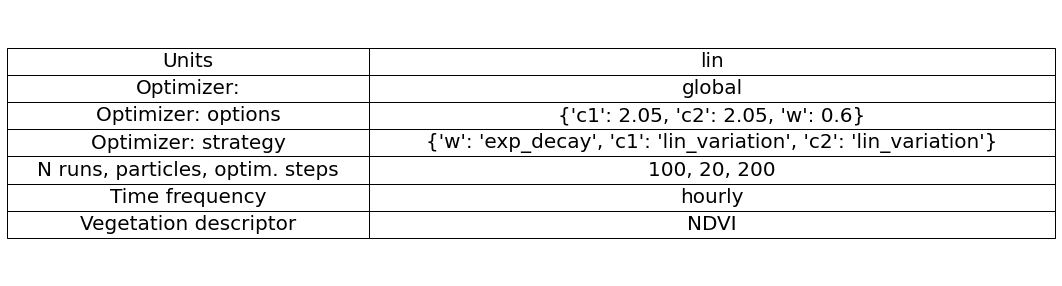

In [22]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
cellText = [
    ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', opt_calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    ['Time frequency', timing],
    ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table_mach.png', dpi=100)
plt.show()

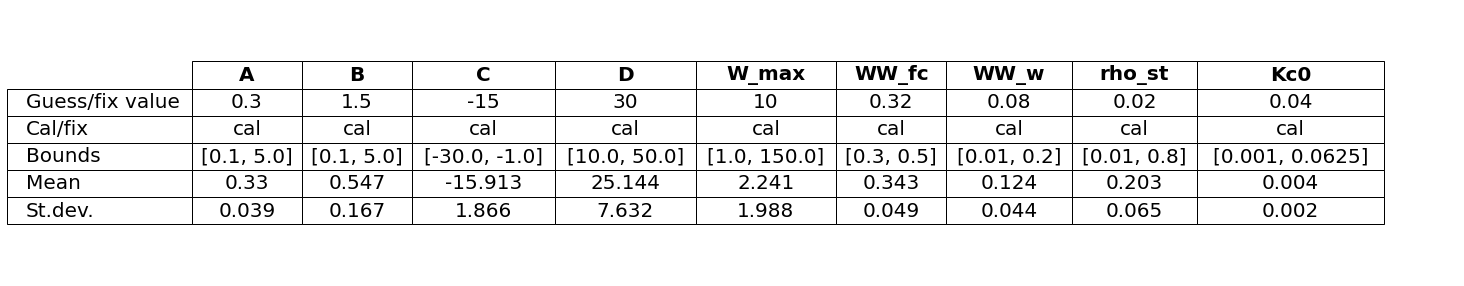

In [23]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

# Table with params
cellText = [[PAR_dict[label][i] for label in PAR_dict] for i in range(5)]
colLabels = [x for x in PAR_dict]
rowLabels = ['Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
plt.show()

## Triple plot SM+$\sigma^0$+inputs

RMSE = 1.6416199702612417
R= 0.6929602205531186
bias = -0.9900172735406051
KGE= 0.6395600399221691
RMSE = 0.06187788714380301
NS = -0.1838828477596417
R (sim vs obs) = 0.5839943492170331


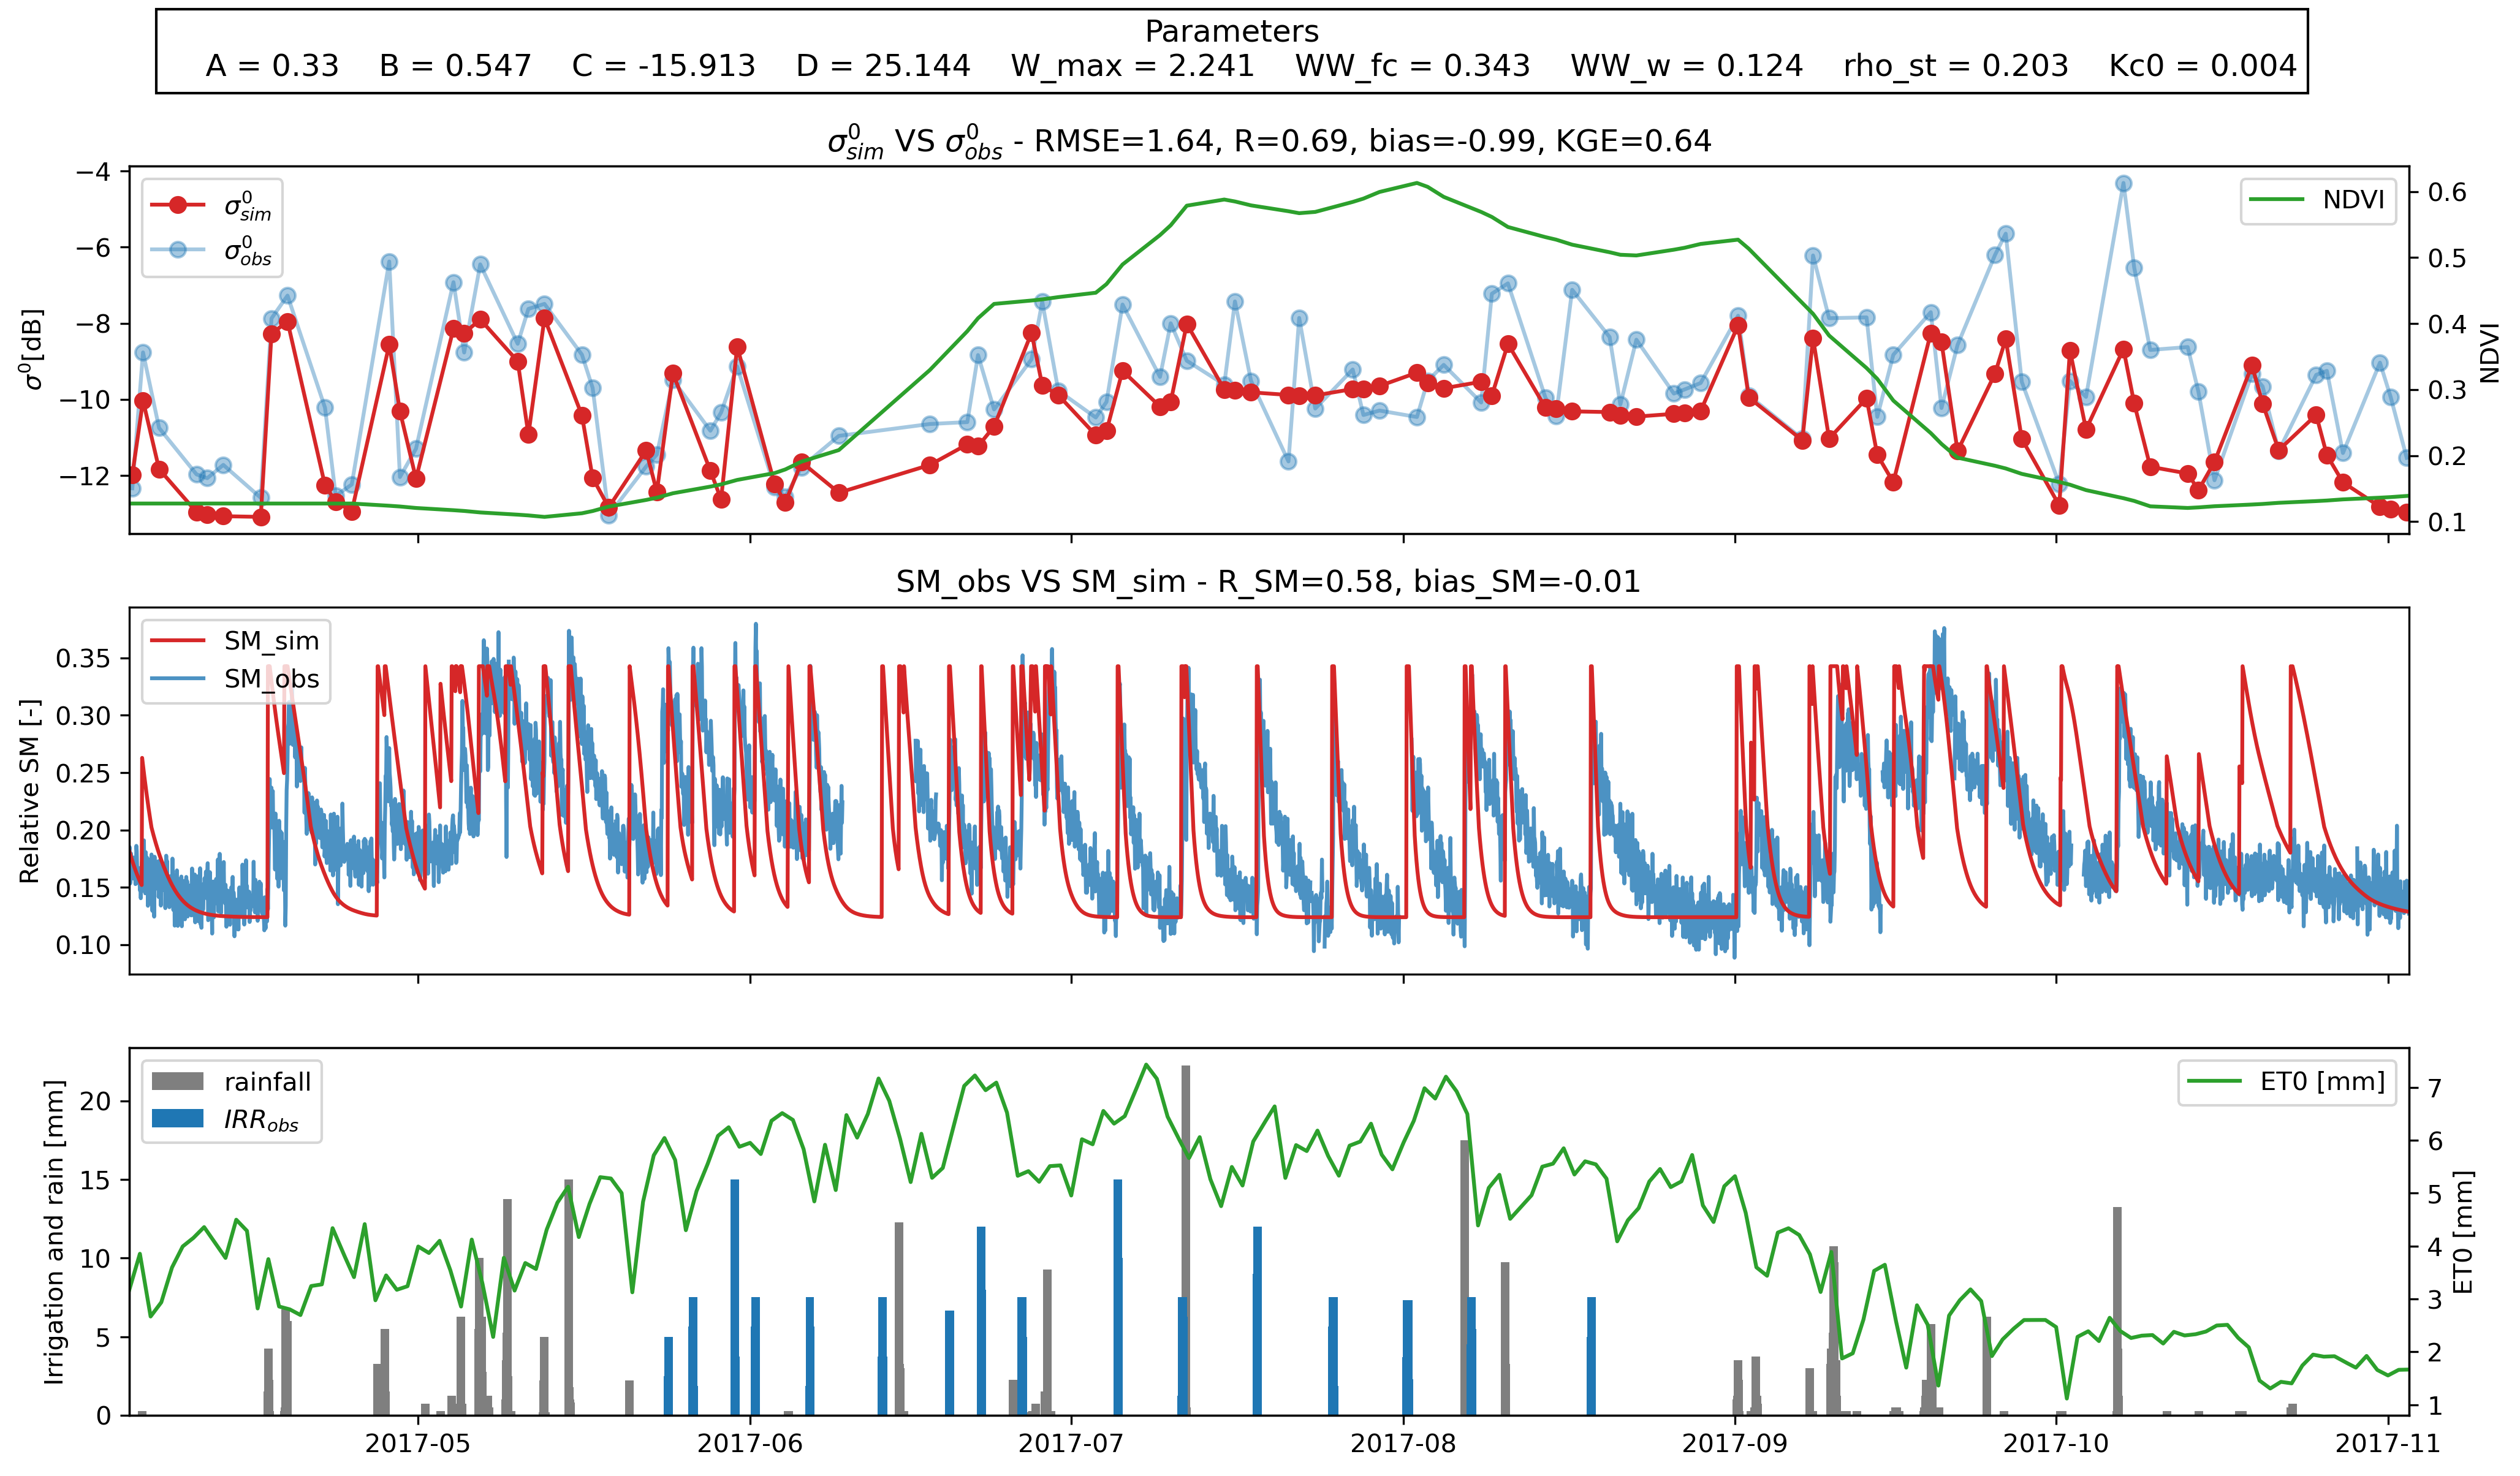

In [24]:
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(16, 9), sharex=True,dpi=300,)
filename = f'triple_'+units+'_'+PAR_str_add

#----------------------------------------------------------------------------
# Box with params

PAR_text='Parameters\n'

try:
    for i in range(len(PAR_str)): PAR_text+=f'    {PAR_str[i]} = {PAR_tot[i]}'
except NameError:
    for label in PAR_dict: PAR_text+=f'    {label} = {PAR_dict[label][3]}'

fig.text(0.5, 0.95,
         PAR_text, ha='center', va='center',
         bbox={'facecolor':'white', 'edgecolor':'black'},
         transform=fig.transFigure,
         fontsize='large',
        )

#----------------------------------------------------------------------------
# Plot of sigma0

obs = VV; obs_label=r'$\sigma^0_{obs}$'
sim = sigma0; sim_label=r'$\sigma^0_{sim}$'
labely = r'$\sigma^0$[dB]'
times = t_sat
marker='o'; linestyle='-'

RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
BIAS=bias(sim,obs); print('bias =', BIAS)
print('KGE=', KGE[0])

title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={BIAS:.2f}, KGE={KGE[0]:.2f}'

ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
ax[0].plot(times, sim, c='tab:red', label=sim_label,
           linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
ax[0].plot(times, obs, c='tab:blue', label=obs_label,
           linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
ax[0].legend(loc='upper left')
ax[0].set_title(title)
ax[0].set_ylabel(labely)

ax1 = ax[0].twinx()
ax1.plot(times, veg, label=opt_veg, color='tab:green')
ax1.legend(loc='upper right')
ax1.set_ylabel(opt_veg)
#----------------------------------------------------------------------------
# Plot of SM

obs = WW_obs; obs_label='SM_obs'
sim = WW; sim_label='SM_sim'
times = t

# RMSE, NS, R, bias calculation
RMSE=np.nanmean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((sim-obs)**2)/np.nansum((obs-np.nanmean(obs))**2); print('NS =', NS)
NS_radQ=1-np.nansum((np.sqrt(sim+0.00001)-np.sqrt(obs+0.00001))**2)/np.nansum((np.sqrt(obs+0.00001)-np.nanmean(np.sqrt(obs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(sim+0.0001)-np.log(obs+0.0001))**2)/np.nansum((np.log(obs+0.0001)-np.nanmean(np.log(obs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

simmatrix = np.array( [ [sim[i], obs[i]] for i in range(len(sim)) if not np.isnan(obs[i]) ] )
R=np.corrcoef(simmatrix,rowvar=False)[0][1]; print('R (sim vs obs) =', R)
BIAS=bias(np.array([e[0] for e in simmatrix]), np.array([e[1] for e in simmatrix]))

if irri:
    IRRmatrix = np.array( [ [IRR[i], IRR_obs[i]] for i in range(len(IRR)) if not np.isnan(IRR_obs[i]) ] )
    R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRR_obs)=', R_IRR)
    B_IRR=bias(np.array([e[0] for e in IRRmatrix]), np.array([e[1] for e in IRRmatrix]))
    irri_title = f'sumIRR_obs={np.sum(IRR_obs):.2f}, '+\
                 f'sumIRR_sim={np.sum(IRR):.2f}, '+\
                 f'R_IRR={R_IRR:.2f}, '+\
                 f'bias_IRR={B_IRR:.2f}, '
else: irri_title=''

title=f'SM_obs VS SM_sim - '+f'{irri_title}'+\
    f'R_SM={R:.2f}, bias_SM={BIAS:.2f}'

ax[1].set_xlim(xmin=times[0], xmax=times[-1])
ax[1].plot(times, sim, c='tab:red', label=sim_label)
ax[1].plot(times, obs, c='tab:blue', label=obs_label, linestyle='-', alpha=.8, zorder=-1)
ax[1].legend(loc='upper left')
ax[1].set_title(title)
ax[1].set_ylabel('Relative SM [-]')

#----------------------------------------------------------------------------
# Plot of inputs P, IRR, veg

times = t

ax[2].bar(times, P, color='tab:gray', label=r'rainfall')
ax[2].bar(times, IRR_obs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[2].legend(loc='upper left')
ax[2].set_ylabel('Irrigation and rain [mm]')

ax2 = ax[2].twinx()
ax2.plot(times, EPOT, label='ET0 [mm]', color='tab:green')
ax2.legend(loc='upper right')
ax2.set_ylabel('ET0 [mm]')

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')

# plt.close()

## Scatterplot

R= 0.5839943492170332 R^2= 0.3410493999174261


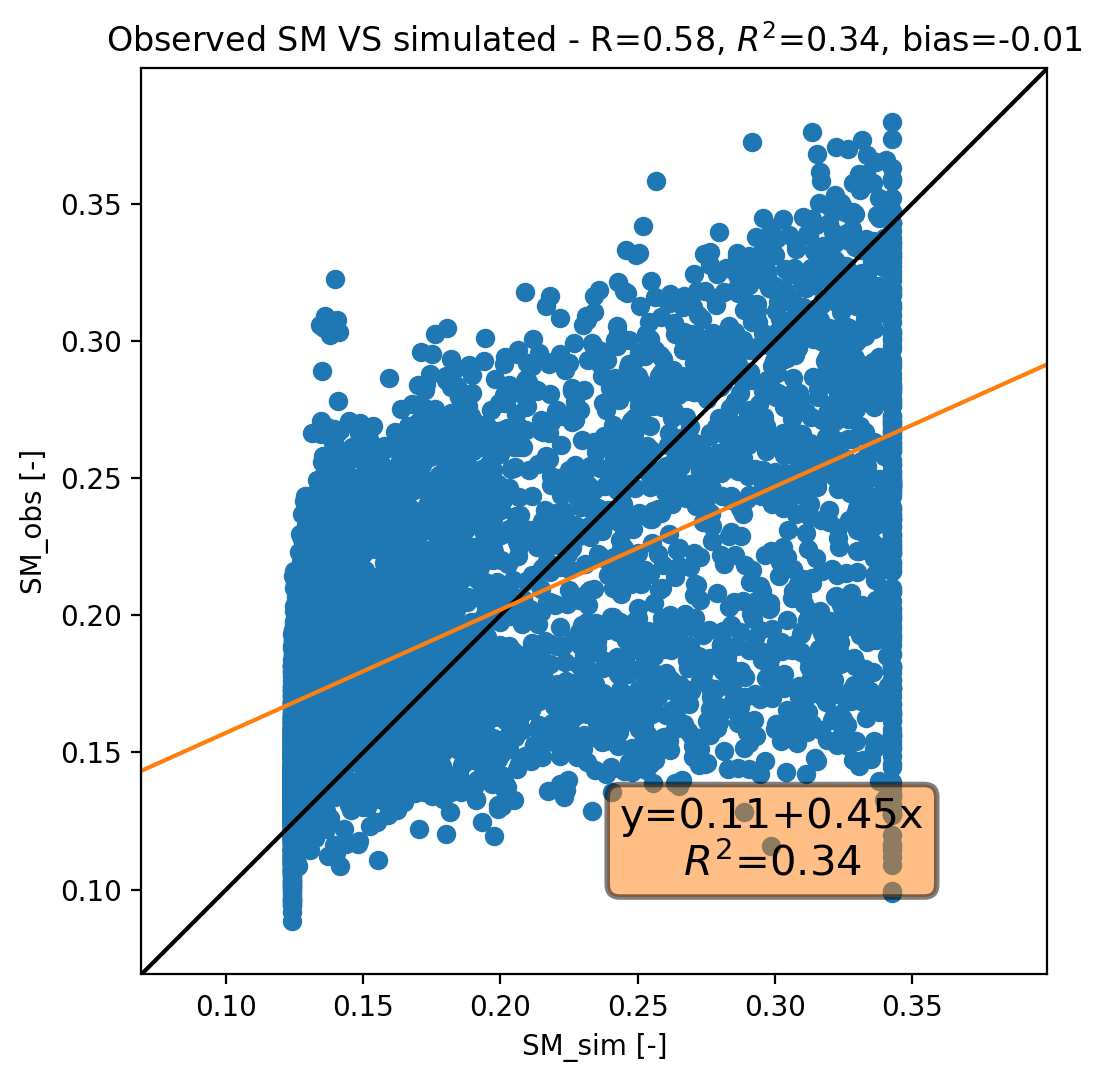

In [25]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

import matplotlib.gridspec as gridspec

def linear(x,a,b):
    return a+b*x

quantity = 'SM'# r'$\sigma^0$' # SM
sim = WW # WW, sigma0
obs = WW_obs # WW_d, VV

title = f'Observed {quantity} VS simulated - ' # y VS x
xlabel = f'{quantity}_sim [-]'
ylabel = f'{quantity}_obs [-]'
filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

data = pd.DataFrame({'sim': sim,'obs': obs})
data.dropna(inplace=True)
x = data.sim.values
y = data.obs.values

fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
ax = plt.subplot(gs[0])
ax.plot(x, y, marker='o', linestyle='', color='tab:blue')
ax.set_xlim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
ax.set_ylim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
lin_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100); ax.plot(lin_grid, lin_grid, color='k')

# Fit
popt, pcov = curve_fit(linear, x, y)
ax.plot(lin_grid, linear(np.array(lin_grid),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(x,y)

ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
ax.text(xtext, ytext,
        f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
        r'$R^2$'+f'={R**2:.2f}',
        ha="center", va="center", size=15,
        bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

ax.set_title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}')
ax.set_aspect('equal', adjustable='box')

if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

R= 0.6929602205531186 R^2= 0.48019386726902674


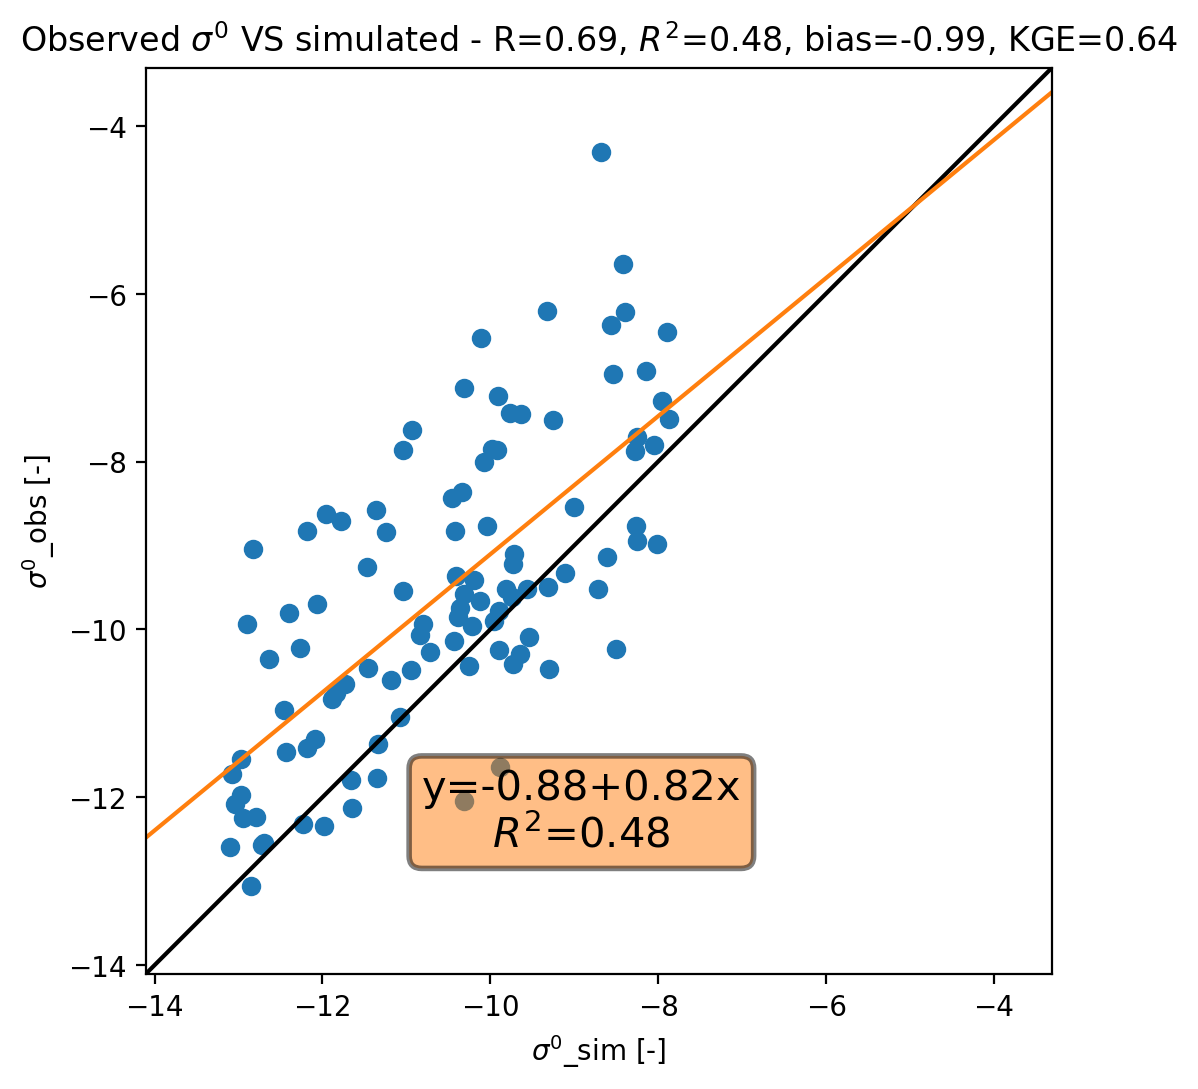

In [26]:
if automate: opt_save = True
else: opt_save = True if input(r'Save scatterplot of $\sigma^0$? [y/n]')=='y' else False

import matplotlib.gridspec as gridspec

def linear(x,a,b):
    return a+b*x

quantity = r'$\sigma^0$' # SM
sim = sigma0 # WW, sigma0
obs = VV # WW_d, VV

title = f'Observed {quantity} VS simulated - ' # y VS x
xlabel = f'{quantity}_sim [-]'
ylabel = f'{quantity}_obs [-]'
filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'SM'
save_choice = 'y' # input(f'Save file? (Filename is '+timestr+'_'+filename+'.png) [y/n]')

data = pd.DataFrame({'sim': sim,'obs': obs})
data.dropna(inplace=True)
x = data.sim.values
y = data.obs.values

fig = plt.figure(figsize=(6, 6), dpi=200)
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
ax = plt.subplot(gs[0])
ax.plot(x, y, marker='o', linestyle='', color='tab:blue')
ax.set_xlim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
ax.set_ylim(np.min([x,y])-0.1*abs(np.mean([x,y])), np.max([x,y])+0.1*abs(np.mean([x,y])))
lin_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100); ax.plot(lin_grid, lin_grid, color='k')

# Fit
popt, pcov = curve_fit(linear, x, y)
ax.plot(lin_grid, linear(lin_grid,*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)
B=bias(x,y)

ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
ax.text(xtext, ytext,
        f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
        r'$R^2$'+f'={R**2:.2f}',
        ha="center", va="center", size=15,
        bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

ax.set_title(title+f'R={R:.2f},'+r' $R^2$'+f'={R**2:.2f}, bias={B:.2f}, KGE={KGE[0]:.2f}')
ax.set_aspect('equal', adjustable='box')

if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')